In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [16]:
files = glob('./data/assignments/*.csv', 
                   recursive = True)
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
# df.loaded_distance = df.loaded_distance.apply(lambda x: x.replace(' mi', '')).astype(float) # Formatting loaded_distance
df['origin'] = pd.Series(zip(df.origin_lat, df.origin_lng))
df['destination'] = pd.Series(zip(df.destination_lat, df.destination_lng))
df = df.drop(['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'], axis=1)
df['trip_type'] = np.NaN
# df = df[:len(df)//100]
print(f"Shape of df: {df.shape}")
df.head()

Shape of df: (188078, 10)


,id,loaded_distance,appt_date,appt_time,client_id,driver_id,program_name,origin,destination,trip_type
0,488034,92.6 mi,2021-09-01,16:30,14352,397,NaN,"(44.38, -75.71)","(43.25, -76.23)",NaN
1,488036,52.6 mi,2021-09-01,06:30,12181,495,ONE,"(43.06, -72.45)","(43.68, -72.27)",NaN
2,488037,92.6 mi,2021-09-01,16:30,14353,397,NaN,"(44.38, -75.71)","(43.25, -76.23)",NaN
3,488038,53.5 mi,2021-09-01,08:40,12181,495,ONE,"(43.68, -72.27)","(43.06, -72.45)",NaN
4,488039,27.2 mi,2021-09-01,16:30,3852,466,NaN,"(43.9, -75.67)","(43.62, -75.36)",NaN


### Trips classification
For now, we define one trip per day per client, and there are 4 types of trips:
- One-way trip: a trip with only 1 leg.
- Round trip: a trip with 2 legs that has the same origin and destination
- Round multi-leg trip: a trip with 3 or more legs that has the same origin and destination
- Non-round multi-leg trip: a trip with **2** or more legs that has the different origin and destination origin and destination. <br>

In [17]:
from tqdm import tqdm
def classify_trip(df):
    df = df.sort_values('appt_time', ascending=True)
    if len(df) == 0:
        return df
    if len(df) == 1:
        df.trip_type = 'one-way'
        return df
    if df.iloc[0].origin == df.iloc[-1].destination:
        if len(df) == 2:
            df.trip_type = 'round'
            return df
        df.trip_type = 'round multi-leg'
        return df
    df.trip_type = 'non-round multi-leg'
    return df
group = df.groupby(['client_id','appt_date'], group_keys=True)
tqdm.pandas(desc=f"Classifying {len(group)} trips in total: ")
classified_df = group.progress_apply(classify_trip)
classified_df = classified_df.drop(['appt_time', 'client_id'], axis=1)
classified_df.head(20)

# Wierd that it continued to run additionally for a while after the process bar says completed.

Classifying 86133 trips in total: 100%|██████████| 86133/86133 [00:45<00:00, 1891.44it/s]


id loaded_distance   appt_date  driver_id  \
client_id appt_date                                                          
48        2021-07-28 154265  470677         94.9 mi  2021-07-28        470   
                     154752  471164          318 mi  2021-07-28        470   
                     154628  471040         94.9 mi  2021-07-28        470   
          2021-08-18 21845   480834         30.5 mi  2021-08-18        235   
                     21979   480968         29.7 mi  2021-08-18        235   
          2021-08-23 24449   483442         37.2 mi  2021-08-23        535   
                     24653   483646         37.2 mi  2021-08-23        535   
          2021-08-26 26311   485305         37.2 mi  2021-08-26        179   
                     26550   485544         37.2 mi  2021-08-26        179   
          2021-08-27 26819   485813         90.9 mi  2021-08-27        177   
                     27035   486029         96.2 mi  2021-08-27        177   
          2021-09-14 5733    493792         95.7 mi  2021-09-14        236   
                     6037    494096         96.4 mi  2021-09-14        236   
          2021-10-11 177658  506382         93.8 mi  2021-10-11        236   
                     177916  506640         94.7 mi  2021-10-11        236   
          2022-07-28 76820   665730         95.3 mi  2022-07-28        129   
                     76993   665903         96.4 mi  2022-07-28        129   
          2022-10-31 109600  716051         96.9 mi  2022-10-31        232   
                     109936  716387         96.4 mi  2022-10-31        232   
          2022-11-17 119613  726084         96.9 mi  2022-11-17        129   

                            program_name           origin      destination  \
client_id appt_date                                                          
48        2021-07-28 154265       STLMCD  (44.93, -74.89)  (43.97, -75.88)   
                     154752       STLMCD  (40.71, -74.01)  (43.97, -75.88)   
                     154628       STLMCD  (43.97, -75.88)  (44.93, -74.89)   
          2021-08-18 21845        STLMCD  (44.93, -74.89)  (44.59, -75.18)   
                     21979        STLMCD  (44.59, -75.18)  (44.93, -74.89)   
          2021-08-23 24449        STLMCD  (44.93, -74.89)   (44.69, -75.5)   
                     24653        STLMCD   (44.69, -75.5)  (44.93, -74.89)   
          2021-08-26 26311        STLMCD  (44.93, -74.89)   (44.69, -75.5)   
                     26550        STLMCD   (44.69, -75.5)  (44.93, -74.89)   
          2021-08-27 26819        STLMCD  (44.93, -74.89)  (43.97, -75.88)   
                     27035        STLMCD  (43.97, -75.88)  (44.93, -74.89)   
          2021-09-14 5733         STLMCD  (44.93, -74.89)  (43.95, -75.91)   
                     6037         STLMCD  (43.95, -75.91)  (44.93, -74.89)   
          2021-10-11 177658       STLMCD  (44.93, -74.89)  (43.97, -75.91)   
                     177916       STLMCD  (43.97, -75.91)  (44.93, -74.89)   
          2022-07-28 76820        STLMCD  (44.93, -74.89)  (43.95, -75.91)   
                     76993        STLMCD  (43.95, -75.91)  (44.93, -74.89)   
          2022-10-31 109600       STLMCD  (44.93, -74.89)  (43.95, -75.91)   
                     109936       STLMCD  (43.95, -75.91)  (44.93, -74.89)   
          2022-11-17 119613       STLMCD  (44.93, -74.89)  (43.95, -75.91)   

                                   trip_type  
client_id appt_date                           
48        2021-07-28 154265  round multi-leg  
                     154752  round multi-leg  
                     154628  round multi-leg  
          2021-08-18 21845             round  
                     21979             round  
          2021-08-23 24449             round  
                     24653             round  
          2021-08-26 26311             round  
                     26550             round  
          2021-08-27 26819             round  
                     27035         

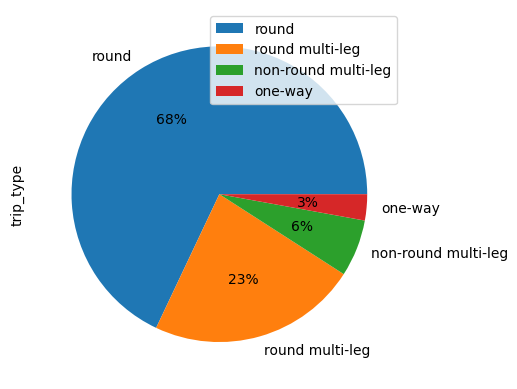

In [18]:
classified_df.trip_type.value_counts().plot(kind='pie',autopct='%0.0f%%', legend=True);

In [19]:
classified_df.trip_type.value_counts()

round                  127834
round multi-leg         43149
non-round multi-leg     11724
one-way                  5371
Name: trip_type, dtype: int64

In [20]:
# Save the above dataframe to assignments_classified.csv
classified_df.to_csv('assignments_classified.csv')